In [1]:
import sys, os

# Always go 1 level up from "transformation for use cases" to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt
from loading.loader import write_to_mysql

spark = SparkSession.builder \
    .appName("Airport Traffic Monitor") \
    .getOrCreate()

parquet_path = "/Users/parthmac/Desktop/Projects/Flight Data Engineering/data/wrangled data/flattened_flight_data_parquet"
df = spark.read.parquet(parquet_path)

df.printSchema()
df.show(5, truncate=False)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/03 15:22:20 WARN Utils: Your hostname, Parths-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.249 instead (on interface en0)
25/09/03 15:22:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/09/03 15:22:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


25/09/03 15:22:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- aircraft_iata: string (nullable = true)
 |-- aircraft_icao: string (nullable = true)
 |-- aircraft_icao24: string (nullable = true)
 |-- aircraft_manufacturer: string (nullable = true)
 |-- aircraft_model: string (nullable = true)
 |-- aircraft_registration: string (nullable = true)
 |-- airline_iata: string (nullable = true)
 |-- airline_icao: string (nullable = true)
 |-- airline_name: string (nullable = true)
 |-- arrival_actual: string (nullable = true)
 |-- arrival_actual_runway: string (nullable = true)
 |-- arrival_airport: string (nullable = true)
 |-- arrival_baggage: string (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_estimated: string (nullable = true)
 |-- arrival_estimated_runway: string (nullable = true)
 |-- arrival_gate: string (nullable = true)
 |-- arrival_iata: string (nullable = true)
 |-- arrival_icao: string (nullable = true)
 |-- arrival_scheduled: string (nullable = true)
 |-- arrival_terminal: string (nullable = true)
 |--

25/09/03 15:22:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------+-------------+---------------+---------------------+--------------+---------------------+------------+------------+------------------+-------------------------+-------------------------+-----------------------------------+---------------+-------------+-------------------------+-------------------------+------------+------------+------------+-------------------------+----------------+----------------+-------------------------+-------------------------+----------------------------------+---------------+-------------------------+--------------------------+--------------+--------------+--------------+-------------------------+------------------+-------------------+------------------------------+------------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------+-----------+-------------+-----------+-------------+----+
|aircraft_iata|aircraft_icao|aircraft_icao24|aircraft_manufac

In [2]:
traffic_df = df.select(
    F.col("flight_date").alias("date"),
    F.col("flight_status").alias("status"),

    F.col("departure_airport").alias("departure_airport_name"),
    F.col("departure_iata").alias("departure_airport_code"),
    F.col("departure_scheduled").alias("departure_time"),

    F.col("arrival_airport").alias("arrival_airport_name"),
    F.col("arrival_iata").alias("arrival_airport_code"),
    F.col("arrival_scheduled").alias("arrival_time"),

    F.col("airline_name").alias("airline"),
    F.col("airline_iata").alias("airline_code")
)

# Show preview
traffic_df.show(5, truncate=False)

+----------+-------+----------------------------------+----------------------+-------------------------+-----------------------------------+--------------------+-------------------------+------------------+------------+
|date      |status |departure_airport_name            |departure_airport_code|departure_time           |arrival_airport_name               |arrival_airport_code|arrival_time             |airline           |airline_code|
+----------+-------+----------------------------------+----------------------+-------------------------+-----------------------------------+--------------------+-------------------------+------------------+------------+
|2025-09-01|landed |Miami International Airport       |MIA                   |2025-09-01T20:02:00+00:00|Budapest Ferenc Liszt International|BUD                 |2025-09-02T05:02:00+00:00|Ethiopian Airlines|ET          |
|2025-09-01|landed |Kuala Lumpur International Airport|KUL                   |2025-09-01T04:09:00+00:00|Riyadh King Khal

In [3]:
# Group by for departures and arrivals
departures = traffic_df.groupBy("date", "departure_airport_code", "departure_airport_name") \
    .agg(F.count("*").alias("departure_count")).alias("d")

arrivals = traffic_df.groupBy("date", "arrival_airport_code", "arrival_airport_name") \
    .agg(F.count("*").alias("arrival_count")).alias("a")

# Join with proper aliasing and qualified column references
traffic_per_airport = departures.join(
    arrivals,
    (F.col("d.date") == F.col("a.date")) &
    (F.col("d.departure_airport_code") == F.col("a.arrival_airport_code")),
    how="outer"
).select(
    F.coalesce(F.col("d.date"), F.col("a.date")).alias("date"),
    F.coalesce(F.col("d.departure_airport_code"), F.col("a.arrival_airport_code")).alias("airport_code"),
    F.coalesce(F.col("d.departure_airport_name"), F.col("a.arrival_airport_name")).alias("airport_name"),
    F.col("d.departure_count"),
    F.col("a.arrival_count")
).fillna(0)

# Show result
traffic_per_airport.orderBy("date", "airport_code").show(truncate=False)

+----------+------------+-------------------------------------------------+---------------+-------------+
|date      |airport_code|airport_name                                     |departure_count|arrival_count|
+----------+------------+-------------------------------------------------+---------------+-------------+
|2025-08-24|AGP         |Malaga Costa Del Sol Airport                     |106            |106          |
|2025-08-24|AKL         |Auckland Airport                                 |98             |99           |
|2025-08-24|ALA         |Almaty International Airport                     |109            |100          |
|2025-08-24|AMM         |Amman Queen Alia Intl                            |91             |95           |
|2025-08-24|AMS         |Amsterdam Schiphol Airport                       |103            |117          |
|2025-08-24|ARN         |Stockholm Arlanda Airport                        |93             |90           |
|2025-08-24|ATH         |Athens Eleftherios Ve

In [4]:
# Step 1: Add total traffic
busiest_airport_df = traffic_per_airport.withColumn(
    "total_traffic", F.col("departure_count") + F.col("arrival_count")
)

# Step 2: First ranking by traffic (and airport_code for tie-breaking)
window_spec = Window.partitionBy("date").orderBy(
    F.desc("total_traffic"), 
    F.asc("airport_code")  # tie-breaker
)

ranked_df = busiest_airport_df.withColumn("rank_raw", F.row_number().over(window_spec))

# Step 3: Deduplicate on (date, airport_code) – keep only first occurrence
deduped_df = ranked_df.dropDuplicates(["date", "airport_code"])

# Step 4: Re-rank after deduplication so we don’t have gaps
window_spec2 = Window.partitionBy("date").orderBy("rank_raw")
final_ranked = deduped_df.withColumn("rank", F.row_number().over(window_spec2))

# Step 5: Keep only top 3 after re-ranking
top_3_df = final_ranked.filter(F.col("rank") <= 3).select(
    "date", "airport_code", "airport_name", 
    "departure_count", "arrival_count", "total_traffic"
)

top_3_df.show(truncate=False)

+----------+------------+-------------------------------------+---------------+-------------+-------------+
|date      |airport_code|airport_name                         |departure_count|arrival_count|total_traffic|
+----------+------------+-------------------------------------+---------------+-------------+-------------+
|2025-08-24|AUH         |Abu Dhabi International Airport      |177            |204          |381          |
|2025-08-24|PNH         |Phnom Penh International             |112            |138          |250          |
|2025-08-24|CMB         |Colombo Bandaranaike Intl            |110            |127          |237          |
|2025-08-25|AUH         |Abu Dhabi International Airport      |209            |209          |418          |
|2025-08-25|LHE         |Lahore Allama Iqbal Intl             |129            |120          |249          |
|2025-08-25|WAW         |Warsaw Chopin Airport                |112            |123          |235          |
|2025-08-26|AUH         |Abu

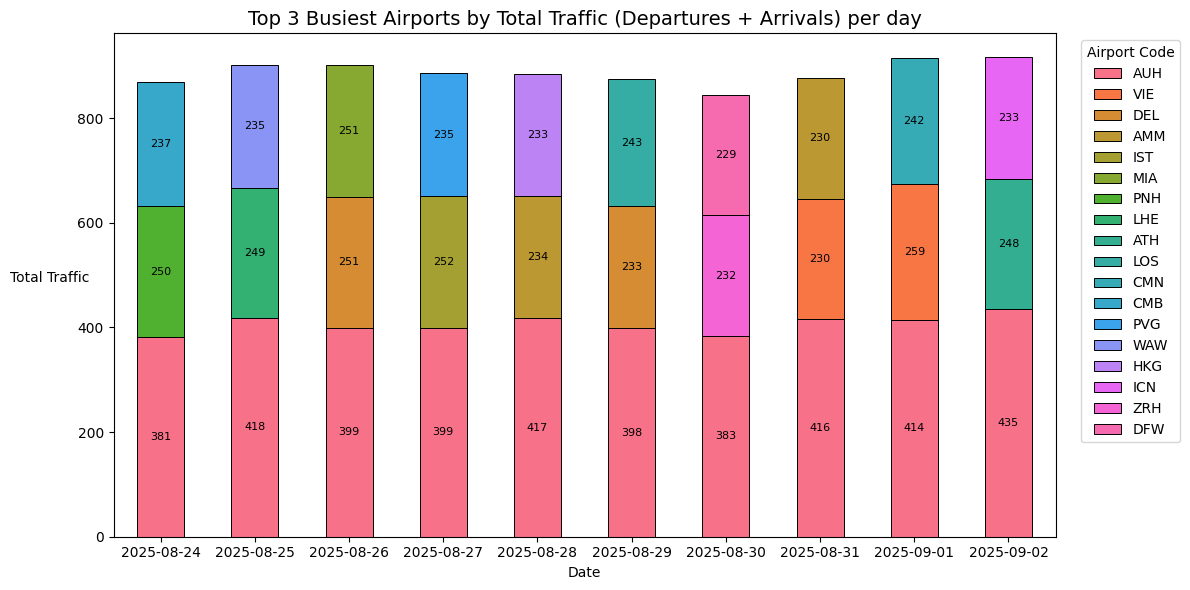

In [5]:
pdf = top_3_df.toPandas()

# Ensure sorting of airports by traffic within each day
pdf = pdf.sort_values(by=["date", "total_traffic"], ascending=[True, False])

# Pivot: rows = dates, cols = airport_code
pivot_df = (
    pdf.pivot(index="date", columns="airport_code", values="total_traffic")
       .fillna(0)
       .sort_index()
)

# Sort columns by total traffic sum (helps consistent order in legend)
pivot_df = pivot_df[pivot_df.sum().sort_values(ascending=False).index]

# --- Colors ---
num_codes = len(pivot_df.columns)
colors = sns.color_palette("husl", n_colors=num_codes)

# --- Stacked Bar Plot ---
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(12,6), 
    color=colors, edgecolor="black", linewidth=0.7 
)

ax.set_title("Top 3 Busiest Airports by Total Traffic (Departures + Arrivals) per day", fontsize=14)
ax.set_ylabel("Total Traffic", rotation=0, labelpad=20)
ax.set_xlabel("Date")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Airport Code", bbox_to_anchor=(1.02, 1), loc="upper left")

# Add counts inside each stack segment
for container in ax.containers:
    labels = [f"{int(bar.get_height())}" if bar.get_height() > 0 else "" for bar in container]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=8)

plt.tight_layout()
plt.show()


In [6]:
# Step 1: Ranking airports per day by departure_count (tie-breaker = airport_code)
w_departure = Window.partitionBy("date").orderBy(
    F.desc("departure_count"), 
    F.asc("airport_code")
)

ranked_departure = traffic_per_airport.withColumn(
    "rank_raw", F.row_number().over(w_departure)
)

# Step 2: Dropping duplicates per (date, airport_code)
dedup_departure = ranked_departure.dropDuplicates(["date", "airport_code"])

# Step 3: Re-ranking after deduplication
w_departure2 = Window.partitionBy("date").orderBy("rank_raw")
final_departure = dedup_departure.withColumn("rank", F.row_number().over(w_departure2))

# Step 4: Keeping top 3 only
top3_departure_df = final_departure.filter(F.col("rank") <= 3).select(
    "date", "airport_code", "airport_name", "departure_count"
).orderBy("date", F.col("departure_count").desc())

top3_departure_df.show(truncate=False)

+----------+------------+-----------------------------------+---------------+
|date      |airport_code|airport_name                       |departure_count|
+----------+------------+-----------------------------------+---------------+
|2025-08-24|AUH         |Abu Dhabi International Airport    |177            |
|2025-08-24|SGN         |Ho Chi Minh Tan Son Nhat Intl      |127            |
|2025-08-24|BKK         |Suvarnabhumi Airport               |122            |
|2025-08-25|AUH         |Abu Dhabi International Airport    |209            |
|2025-08-25|LHE         |Lahore Allama Iqbal Intl           |129            |
|2025-08-25|KWI         |Kuwait International Airport       |122            |
|2025-08-26|AUH         |Abu Dhabi International Airport    |197            |
|2025-08-26|DEL         |Indira Gandhi International Airport|130            |
|2025-08-26|MIA         |Miami International Airport        |128            |
|2025-08-27|AUH         |Abu Dhabi International Airport    |201

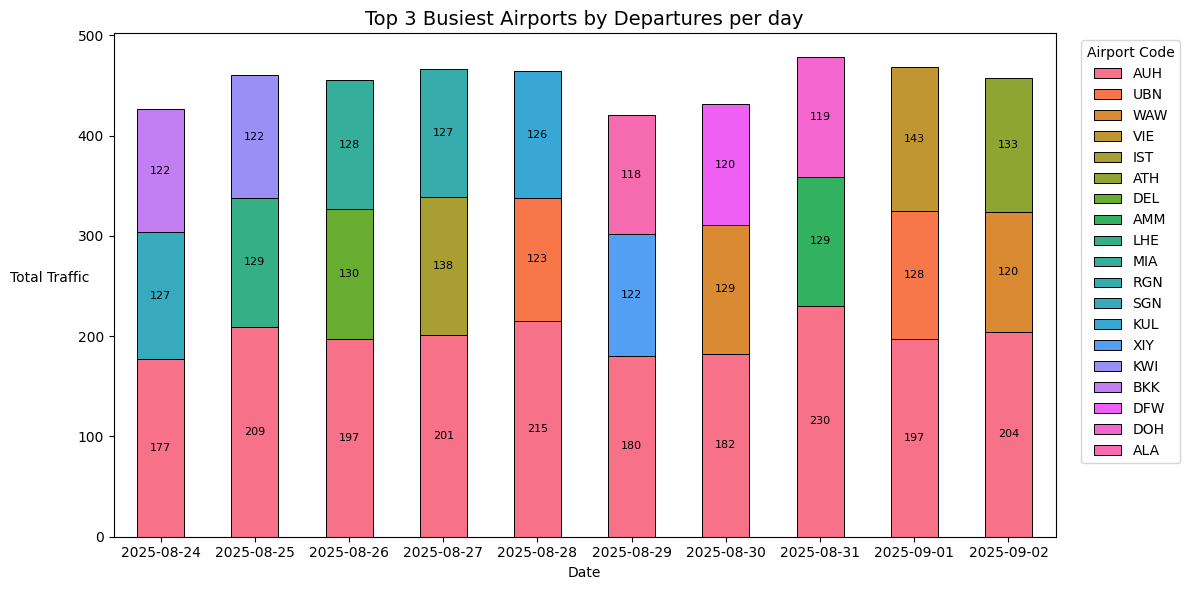

In [7]:
# Convert to Pandas
pdf = top3_departure_df.toPandas()

# Ensure sorting of airports by traffic within each day
pdf = pdf.sort_values(by=["date", "departure_count"], ascending=[True, False])

# Pivot: rows = dates, cols = airport_code
pivot_df = (
    pdf.pivot(index="date", columns="airport_code", values="departure_count")
       .fillna(0)
       .sort_index()
)

# Sort columns by total traffic sum (helps consistent order in legend)
pivot_df = pivot_df[pivot_df.sum().sort_values(ascending=False).index]

# --- Colors ---
num_codes = len(pivot_df.columns)
colors = sns.color_palette("husl", n_colors=num_codes)

# --- Stacked Bar Plot ---
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(12,6), 
    color=colors, edgecolor="black", linewidth=0.7 
)

ax.set_title("Top 3 Busiest Airports by Departures per day", fontsize=14)
ax.set_ylabel("Total Traffic", rotation=0, labelpad=20)
ax.set_xlabel("Date")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Airport Code", bbox_to_anchor=(1.02, 1), loc="upper left")

# Add counts inside each stack segment
for container in ax.containers:
    labels = [f"{int(bar.get_height())}" if bar.get_height() > 0 else "" for bar in container]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=8)

plt.tight_layout()
plt.show()


In [8]:
# Step 1: Rank airports per day by arrival_count (tie-breaker = airport_code)
w_arrival = Window.partitionBy("date").orderBy(
    F.desc("arrival_count"), 
    F.asc("airport_code")
)

ranked_arrival = traffic_per_airport.withColumn(
    "rank_raw", F.row_number().over(w_arrival)
)

# Step 2: Drop duplicates per (date, airport_code)
dedup_arrival = ranked_arrival.dropDuplicates(["date", "airport_code"])

# Step 3: Re-rank after deduplication
w_arrival2 = Window.partitionBy("date").orderBy("rank_raw")
final_arrival = dedup_arrival.withColumn("rank", F.row_number().over(w_arrival2))

# Step 4: Keep top 3 only
top3_arrival_df = final_arrival.filter(F.col("rank") <= 3).select(
    "date", "airport_code", "airport_name", "arrival_count"
).orderBy("date", F.col("arrival_count").desc())

top3_arrival_df.show(truncate=False)


+----------+------------+-----------------------------------+-------------+
|date      |airport_code|airport_name                       |arrival_count|
+----------+------------+-----------------------------------+-------------+
|2025-08-24|AUH         |Abu Dhabi International Airport    |204          |
|2025-08-24|PNH         |Phnom Penh International           |138          |
|2025-08-24|CMB         |Colombo Bandaranaike Intl          |127          |
|2025-08-25|AUH         |Abu Dhabi International Airport    |209          |
|2025-08-25|UBN         |Ulaanbaatar Chinggis Khaan Intl    |123          |
|2025-08-25|WAW         |Warsaw Chopin Airport              |123          |
|2025-08-26|AUH         |Abu Dhabi International Airport    |202          |
|2025-08-26|CPT         |Cape Town International Airport    |133          |
|2025-08-26|LHR         |London Heathrow Airport            |128          |
|2025-08-27|AUH         |Abu Dhabi International Airport    |198          |
|2025-08-27|

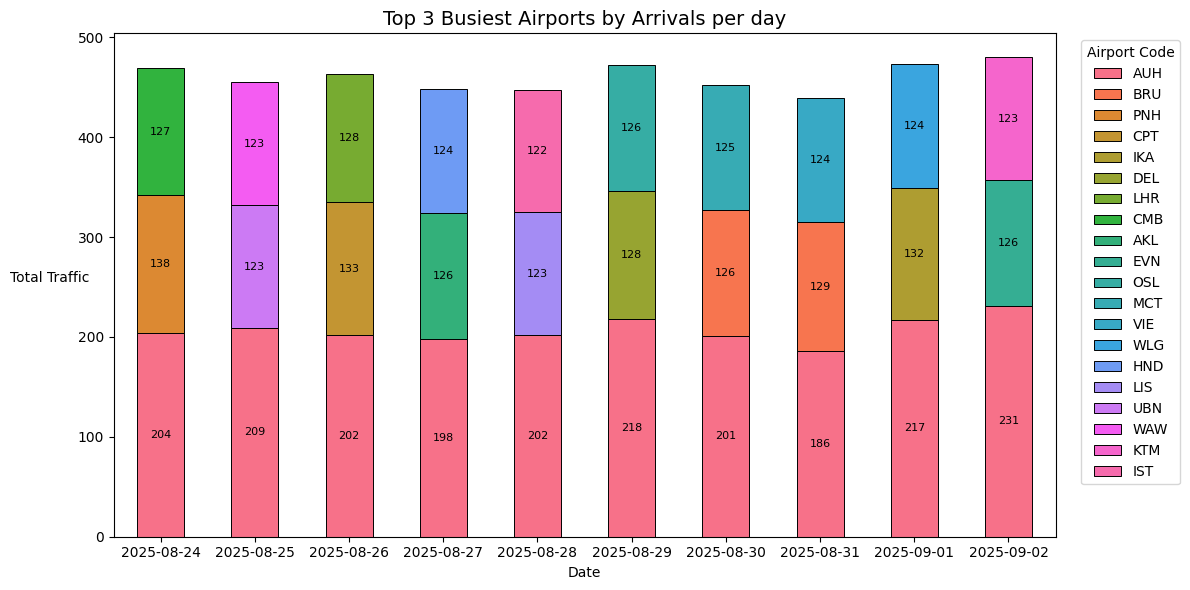

In [9]:
# Convert to Pandas
pdf = top3_arrival_df.toPandas()

# Ensure sorting of airports by traffic within each day
pdf = pdf.sort_values(by=["date", "arrival_count"], ascending=[True, False])

# Pivot: rows = dates, cols = airport_code
pivot_df = (
    pdf.pivot(index="date", columns="airport_code", values="arrival_count")
       .fillna(0)
       .sort_index()
)

# Sort columns by total traffic sum (helps consistent order in legend)
pivot_df = pivot_df[pivot_df.sum().sort_values(ascending=False).index]

# --- Colors ---
num_codes = len(pivot_df.columns)
colors = sns.color_palette("husl", n_colors=num_codes)

# --- Stacked Bar Plot ---
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(12,6), 
    color=colors, edgecolor="black", linewidth=0.7 
)

ax.set_title("Top 3 Busiest Airports by Arrivals per day", fontsize=14)
ax.set_ylabel("Total Traffic", rotation=0, labelpad=20)
ax.set_xlabel("Date")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Airport Code", bbox_to_anchor=(1.02, 1), loc="upper left")

# Add counts inside each stack segment
for container in ax.containers:
    labels = [f"{int(bar.get_height())}" if bar.get_height() > 0 else "" for bar in container]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
#loading our dataframes to mysql after final transformations
write_to_mysql(top_3_df, "top_3_busiest_airports_daily", mode="overwrite")
write_to_mysql(top3_departure_df, "top_3_busiest_departure_airports_daily", mode="overwrite")
write_to_mysql(top3_arrival_df, "top_3_busiest_arrival_airports_daily", mode="overwrite")

✅ Data written to MySQL (localhost:3306/flight_db) → Table: top_3_busiest_airports_daily


✅ Data written to MySQL (localhost:3306/flight_db) → Table: top_3_busiest_departure_airports_daily


✅ Data written to MySQL (localhost:3306/flight_db) → Table: top_3_busiest_arrival_airports_daily
